# Handwriting EDA

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
# Create some visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# Define data_path
data_path = '/kaggle/input/handwritten-parkinsons-disease-augmented-data/Dataset'

# Get the number of images in this folder
healthy = glob.glob(os.path.join(data_path, 'Dataset/Healthy/*.png'))
parkisons = glob.glob(os.path.join(data_path, 'Dataset/Parkinson/*.png'))

# Graph the healthy and parkisons data
print("healthy: ", len(healthy))
print("parkisons: ", len(parkisons))
print("total: ", len(healthy) + len(parkisons))

healthy:  1632
parkisons:  1632
total:  3264


In [25]:
# Split data into training, validation, and testing sets
'''
# Load images from the Healthy folder
healthy_images = glob.glob(os.path.join(data_path, 'Dataset/Healthy/*.png'))

# Load images from the Parkinson folder
parkinson_images = glob.glob(os.path.join(data_path, 'Dataset/Parkinson/*.png'))

# Rename images the path is /Dataset/Healthy/x
for i, img in enumerate(healthy_images):
    correct_name = img.replace(data_path, '')
    healthy_images[i] = correct_name

for i, img in enumerate(parkinson_images):
    correct_name = img.replace(data_path, '')
    parkinson_images[i] = correct_name

# Split data for Healthy images
healthy_train, healthy_test = train_test_split(healthy_images, test_size=0.15, random_state=42)
healthy_train, healthy_val = train_test_split(healthy_train, test_size=0.15, random_state=42)

# Split data for Parkinson images
parkinson_train, parkinson_test = train_test_split(parkinson_images, test_size=0.15, random_state=42)
parkinson_train, parkinson_val = train_test_split(parkinson_train, test_size=0.15, random_state=42)

# Combine the sets
train_images = healthy_train + parkinson_train
val_images = healthy_val + parkinson_val
test_images = healthy_test + parkinson_test

print("Training set size:", len(train_images))
print("Validation set size:", len(val_images))
print("Testing set size:", len(test_images))
'''

Training set size: 2356

Validation set size: 418

Testing set size: 490


In [28]:
'''print(train_images[0])

# Create csv files for the training, validation, and testing sets

# Get labels from the image path
def get_label(image_path):
    if 'Healthy' in image_path:
        return 0
    elif 'Parkinson' in image_path:
        return 1
    else:
        return None

if not os.path.exists('/Users/katiegreed/Documents/Duke AI Masters/AIPI 540 - Deep Learning/Ind Proj/handwriting_data/train.csv'):
    # Loop through the images and write to csv
    for image in train_images:
        # Write to csv
        with open(os.path.join(data_path, 'train.csv'), 'a') as f:
            f.write(f'{image},{get_label(image)}\n')
    for image in val_images:
        with open(os.path.join(data_path, 'val.csv'), 'a') as f:
            f.write(f'{image},{get_label(image)}\n')
    for image in test_images:
        with open(os.path.join(data_path, 'test.csv'), 'a') as f:
            f.write(f'{image},{get_label(image)}\n')
'''

Dataset/Healthy/Healthy152.png


In [6]:
# Read from split
train_images = pd.read_csv('/kaggle/input/parkinsons-handwriting-split/train.csv')
val_iamges = pd.read_csv('/kaggle/input/parkinsons-handwriting-split/val.csv')
test_images = pd.read_csv('/kaggle/input/parkinsons-handwriting-split/test.csv')

In [7]:
train_images.head()

,img,label
0,Dataset/Healthy/Healthy152.png,0
1,Dataset/Healthy/Healthy297.png,0
2,Dataset/Healthy/Healthy1279.png,0
3,Dataset/Healthy/Healthy276.png,0
4,Dataset/Healthy/Healthy904.png,0


## Model the data

### Create a computer vision model that recognizes handwriting as either healthy or parkinson

### Data has already been augmented with flipping, rotations, etc.

### ResNet50

In [9]:
!pip install torchsummary

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import os
from torchsummary import summary  
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [37]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, base_dir=data_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            base_dir (string): path of base directory.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.base_dir, self.data_frame.iloc[idx, 0])
        
        image = Image.open(img_name).convert('RGB')
        
        label = self.data_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        # Map class names to numerical labels
        #self.class_to_label = {
            #'healthy': 0,
            #'parkinson': 1
        #}
        #label = self.class_to_label[label]
        return image, label

def load_data(train_csv, val_csv, test_csv, base_dir=data_path):
    # Apply any transformations here
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = CustomDataset(csv_file=train_csv, base_dir=base_dir, transform=transform)
    val_dataset = CustomDataset(csv_file=val_csv, base_dir=base_dir, transform=transform)
    test_dataset = CustomDataset(csv_file=test_csv, base_dir=base_dir, transform=transform)

    return train_dataset, val_dataset, test_dataset


In [30]:
# Define dataloaders
def setup_dataloaders(train_csv='/kaggle/input/parkinsons-handwriting-split/train.csv', val_csv='/kaggle/input/parkinsons-handwriting-split/val.csv', test_csv='/kaggle/input/parkinsons-handwriting-split/test.csv', batch_size=32):
    train_dataset, val_dataset, test_dataset = load_data(train_csv, val_csv, test_csv)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [39]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=15, patience=3, filename='resnet50_model.pth', device='cuda'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0  # For early stopping
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # Save the loss and accuracy for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0  # Reset counter
                # Save the model
                print(f"Saving model to models_saved/{filename}")
                torch.save(model.state_dict(), os.path.join('/kaggle/working/', f'{filename}_{epoch}.pth'))
            elif phase == 'val':
                epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping")
            break

    print('Training complete. Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

#### Main to run resnet

In [35]:
# Define RESNET50 model
model = models.resnet50(weights=True)
#summary(model, torch.zeros(1,3,224,224))
for param in model.parameters():
    param.requires_grad = False

# Modify pooling layer
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

# Replace last FC layer
model.fc = nn.Sequential(nn.Flatten(),
nn.Linear(2048, 256),
nn.ReLU(),
nn.Dropout(0.2),
nn.Linear(256, 11))

#summary(model, torch.zeros(1,3,224,224))
#print(model)

Model moved to cuda:0
Epoch 1/70
----------
train Loss: 0.1837 Acc: 0.9278
val Loss: 0.2312 Acc: 0.8923
Saving model to models_saved/Resnet50
Epoch 2/70
----------
train Loss: 0.1867 Acc: 0.9240
val Loss: 0.2308 Acc: 0.8923
Epoch 3/70
----------
train Loss: 0.1933 Acc: 0.9198
val Loss: 0.1917 Acc: 0.9282
Saving model to models_saved/Resnet50
Epoch 4/70
----------
train Loss: 0.1809 Acc: 0.9291
val Loss: 0.1973 Acc: 0.9187
Epoch 5/70
----------
train Loss: 0.1716 Acc: 0.9312
val Loss: 0.1892 Acc: 0.9306
Saving model to models_saved/Resnet50
Epoch 6/70
----------
train Loss: 0.1992 Acc: 0.9194
val Loss: 0.2164 Acc: 0.9019
Epoch 7/70
----------
train Loss: 0.1676 Acc: 0.9380
val Loss: 0.2004 Acc: 0.9163
Epoch 8/70
----------
train Loss: 0.1629 Acc: 0.9359
val Loss: 0.2053 Acc: 0.9115
Epoch 9/70
----------
train Loss: 0.1668 Acc: 0.9376
val Loss: 0.2145 Acc: 0.9187
Epoch 10/70
----------
train Loss: 0.1689 Acc: 0.9342
val Loss: 0.1755 Acc: 0.9402
Saving model to models_saved/Resnet50
Epoch

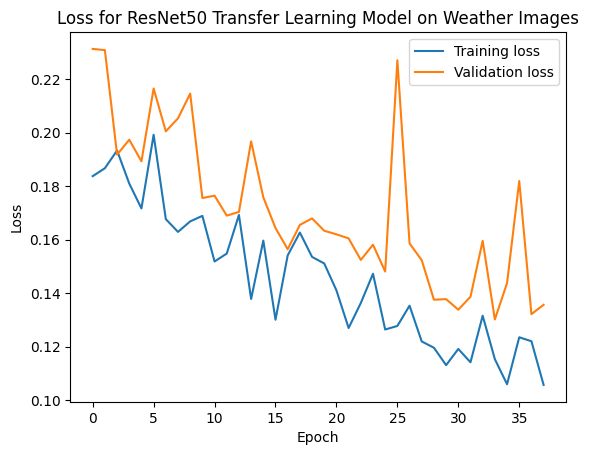

<Figure size 640x480 with 0 Axes>

In [42]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model moved to {device}")

# set up data loaders
train_loader, val_loader, test_loader = setup_dataloaders()
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epohs = 70
earlystopping = 8

#Run Name
description = 'Resnet50'

# Train the model
model_ft, train_loss, val_loss, train_acc, val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=epohs, patience=earlystopping, filename= description)


# Save the training and validation losses to a txt file
with open(os.path.join('/kaggle/working/',f'{description}.txt'), 'w') as f:
    for i in range(len(train_loss)):
        f.write(f"Epoch {i+1} - Train Loss: {train_loss[i]} - Val Loss: {val_loss[i]} - Train Acc: {train_acc[i]} - Val Acc: {val_acc[i]}\n")

# Plot the training and validation loss
plt.figure(0)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for ResNet50 Transfer Learning Model on Weather Images')
plt.show()
plt.savefig(os.path.join('/kaggle/working/',f'{description}_loss.png'))

In [43]:
# Save best model to download from kaggle
torch.save(model.state_dict(), os.path.join('/kaggle/working/', f'best_resNet50.pth'))

### Test Model

In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, auc
def test_model(model_path, test_loader, model_name, device='cuda'):

    # Put the model in evaluation mode
    model.eval()

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    pred_labels = []
    pred_probs = []

    # Iterate through the test data and make predictions
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())  # Use the predicted labels directly
        pred_probs.extend(softmax_probs.cpu().numpy())

    #pred_probs = np.array(pred_probs)

    # Compute overall accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted')
    recall = recall_score(true_labels, pred_labels, average='weighted')
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    # Write evaluation metrics to a text file
    evaluation_file = f"/kaggle/working/{model_name}_evaluation.txt"
    with open(evaluation_file, 'w') as f:
        f.write(f"Model: {model_name}\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n\n")

    # Print evaluation metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    class_to_label = {0: 'healthy', 1: 'parkinsons'}

    # Compute and plot confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_to_label))
    plt.xticks(tick_marks, class_to_label.values(), rotation=45)
    plt.yticks(tick_marks, class_to_label.values())
    # Add numbers to each box
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > np.max(cm) / 2 else "black")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(f"/kaggle/working/{model_name}_confusion_matrix.png")
    plt.show()

Model: ResNet50
Accuracy: 0.9531
Precision: 0.9531
Recall: 0.9531
F1-score: 0.9531


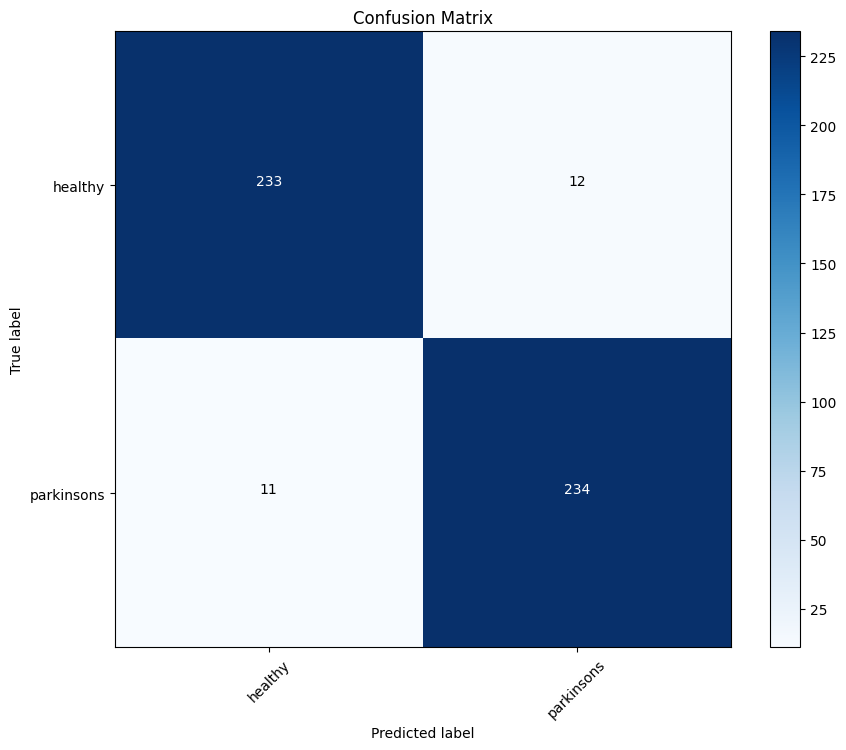

In [63]:
# Move the test data to the GPU
test_data = []
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    test_data.append((data, target))

test_model(model, test_data, 'ResNet50')